# Importación de las librerias y carga de archivo STL del Gomboc

In [78]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import griddata

In [79]:
stl = int(3)  # Seleccionar el archivo STL a usar

# Diccionario con las rutas de los archivos STL
stl_paths = {
    1: r"C:\Users\david\Material-Universidad\Retos\STL\20000_polygon_sphere_100mm.STL",
    2: r"C:\Users\david\Material-Universidad\Retos\STL\Monostatic_Body_Release.STL",
    3: r"C:\Users\david\Material-Universidad\Retos\STL\GollyPoly.stl",
    }

# Usar el archivo correspondiente dependiendo de prueba
mesh = trimesh.load_mesh(stl_paths[stl])

# Calculo del Tensor de Inercia diagonalizado y los ejes principales de inercia

In [80]:
# Calcular el volumen, centro de masa y el tensor de inercia
volume = mesh.volume
centroid = mesh.center_mass
inertia_tensor = mesh.moment_inertia  # Si deseas considerar densidad, multiplica por la densidad

print("Volumen:", volume)
print("Centro de masa:", centroid)

# Suponiendo que 'inertia_tensor' es tu tensor de inercia 3x3:
eigvals, eigvecs = np.linalg.eigh(inertia_tensor)

print("Momentos principales de inercia:", eigvals)
print("Ejes principales (columnas de eigvecs):", eigvecs)

Volumen: 377.3968380503409
Centro de masa: [-1.24521328e-01 -4.68509059e-11  5.00000007e+00]
Momentos principales de inercia: [2689.2567325  3277.47224616 3412.60221449]
Ejes principales (columnas de eigvecs): [[-9.36497537e-08  1.00000000e+00  7.13636356e-10]
 [ 4.17510471e-12 -7.13636356e-10  1.00000000e+00]
 [-1.00000000e+00 -9.36497537e-08  4.17477164e-12]]


# Grafica de los eigenvectors o vectores propios del movimiento del Gomboc

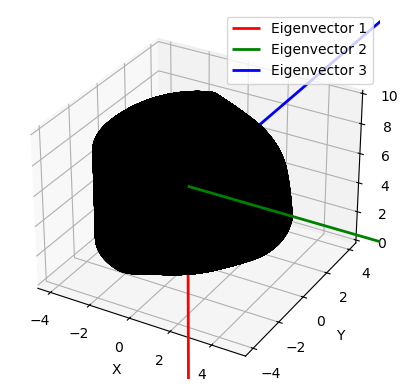

In [81]:
# Crear figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Graficar la malla STL
ax.add_collection3d(Poly3DCollection(mesh.vertices[mesh.faces], alpha=0.5, edgecolor="k"))

# Graficar los vectores propios en el centro de masa
colors = ['r', 'g', 'b']  # Colores para los ejes principales
scale = np.max(eigvals) ** 0.5  # Escalar los vectores para visualización

for i in range(3):  # Para cada eje principal
    ax.quiver(centroid[0], centroid[1], centroid[2], 
              eigvecs[0, i] * scale, eigvecs[1, i] * scale, eigvecs[2, i] * scale, 
              color=colors[i], linewidth=2, label=f'Eigenvector {i+1}')

# Configurar la visualización
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.auto_scale_xyz(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2])

# Mostrar leyenda y gráfico
ax.legend()
plt.show()

# Se definen los triangulos del archivo STL

In [82]:
# Obtener los vértices y caras de la malla
vertices = mesh.vertices
faces = mesh.faces

# Definicion de la posicion de los vertices de cada triangulo
V1 = vertices[faces[:, 0]]
V2 = vertices[faces[:, 1]]
V3 = vertices[faces[:, 2]]

# Calculo de los vectores normales a la superficie

In [83]:
# Producto cruzado de los lados del triángulo
normals = np.cross(V2 - V1, V3 - V1)

# Normalizar los vectores normales
normals /= np.linalg.norm(normals, axis=1, keepdims=True)

print(normals)

[[ 8.42704825e-03 -3.67932953e-05 -9.99964491e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]
 ...
 [ 8.86283117e-01  4.48823355e-01  1.14279622e-01]
 [ 8.86430157e-01  4.48529644e-01  1.14292323e-01]
 [ 8.85658755e-01  4.50068933e-01  1.14221383e-01]]


# Calculo de los vectores desde el centro de masa a la superficie

In [84]:
midpoints = (V1 + V2 + V3) / 3  # Puntos medios de los triángulos

# Calcular los vectores desde el centro de masa a cada punto medio
vectors = midpoints - centroid

print(vectors)

[[ 1.73470665e-01 -1.26562636e-04 -4.99989893e+00]
 [ 1.60778774e-01 -1.26562636e-04 -4.99994478e+00]
 [ 1.53526898e-01 -1.89843977e-04 -4.99994478e+00]
 ...
 [ 5.06779487e+00  6.77607788e-05  2.52501734e-01]
 [ 5.06657862e+00  1.96808982e-03  2.54476793e-01]
 [ 5.06774989e+00  1.37959960e-04  2.52574849e-01]]


# Calculo de la altura del centro de masa

In [85]:
def altura_centro_masa(vectors, normals):
    """
    Calcula la proyección (producto punto) de cada vector sobre su correspondiente normal.
    Parámetros:
      vectors : np.ndarray de shape (N, 3)
          Vectores desde el centro de masa hasta los centros de los triángulos.
      normals : np.ndarray de shape (N, 3)
          Vectores normales (normalizados) de cada triángulo.
    Retorna:
      alturas : np.ndarray de shape (N,)
          Producto punto de cada par, que se interpretará como la "altura".
    """
    alturas = np.sum(vectors * normals, axis=1)
    return alturas

In [86]:
# Calculamos las alturas (proyecciones)
alturas = altura_centro_masa(vectors, normals)
print("Alturas (proyecciones del vector desde el centro de masa):\n", alturas)

Alturas (proyecciones del vector desde el centro de masa):
 [5.00118324 4.99994478 4.99994478 ... 4.52038725 4.52113557 4.5172086 ]


# Parametrización de los vectores con respecto a theta y phi

In [87]:
def compute_theta_phi(vectors, eigvecs):
    """
    Calcula los ángulos theta y phi de cada vector usando las definiciones:
      theta = arccos(z / r)
      phi   = sgn(y) * arccos(x / sqrt(x^2 + y^2))
    donde:
      - e2 = eigvecs[:, 1] es el eje 'z'
      - e1 = eigvecs[:, 0] es el eje 'x'
      - e3 = e2 x e1       es el eje 'y'
    
    Parámetros:
      vectors : np.ndarray de shape (N, 3)
          Vectores en coordenadas cartesianas (originales).
      eigvecs : np.ndarray de shape (3, 3)
          Matriz de eigenvectores, donde cada columna es un eigenvector.
          - eigvecs[:, 2] = e3
          - eigvecs[:, 1] = e2
          - eigvecs[:, 0] = e1

    Retorna:
      theta : np.ndarray de shape (N,)
          Ángulo polar (definición de la imagen).
      phi   : np.ndarray de shape (N,)
          Ángulo azimutal (definición de la imagen).
    """
    # 1. Normalizamos e2 y e1
    e2 = eigvecs[:, 1] / np.linalg.norm(eigvecs[:, 1])  # Eje "z"
    e1 = eigvecs[:, 0] / np.linalg.norm(eigvecs[:, 0])  # Eje "x"
    e3 = eigvecs[:, 2] / np.linalg.norm(eigvecs[:, 2])  # Eje "y"
    
    # Para cada vector, calculamos sus componentes en el sistema (e1, e2, e3)
    #   x' = v · e1
    #   y' = v · e3
    #   z' = v · e2
    x_comp = np.dot(vectors, e1)
    y_comp = np.dot(vectors, e3)
    z_comp = np.dot(vectors, e2)
    
    # Norma de cada vector en este nuevo sistema
    r = np.sqrt(x_comp**2 + y_comp**2 + z_comp**2)
    # Para evitar división por cero
    r_safe = np.where(r == 0, 1, r)
    
    # --------------------
    # Cálculo de theta
    # --------------------
    # theta = arccos(z / r)
    # Clipeamos el argumento de arccos a [-1,1] para evitar errores numéricos
    cos_theta = z_comp / r_safe
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    
    # --------------------
    # Cálculo de phi
    # --------------------
    # phi = sgn(y) * arccos(x / sqrt(x^2 + y^2))
    # Definimos el denominador para x^2 + y^2
    xy_norm = np.sqrt(x_comp**2 + y_comp**2)
    xy_norm_safe = np.where(xy_norm == 0, 1, xy_norm)  # evitar 0 en la división
    
    # arccos(x / sqrt(x^2 + y^2))
    arg_phi = x_comp / xy_norm_safe
    arg_phi = np.clip(arg_phi, -1.0, 1.0)  # clip para evitar fuera de dominio
    base_phi = np.arccos(arg_phi)
    
    # sgn(y)
    sgn_y = np.sign(y_comp)
    
    # Producto final
    phi = sgn_y * base_phi
    
    return theta, phi

In [88]:
# Parametrización
theta, phi = compute_theta_phi(vectors, eigvecs)
print("Theta:", min(theta), max(theta))
print("Phi:", min(phi), max(phi))

Theta: 0.0029772670648055225 3.137899781404848
Phi: -3.141592653589793 3.141592653589793


# Gráfica proporcional del potencial gravitacional

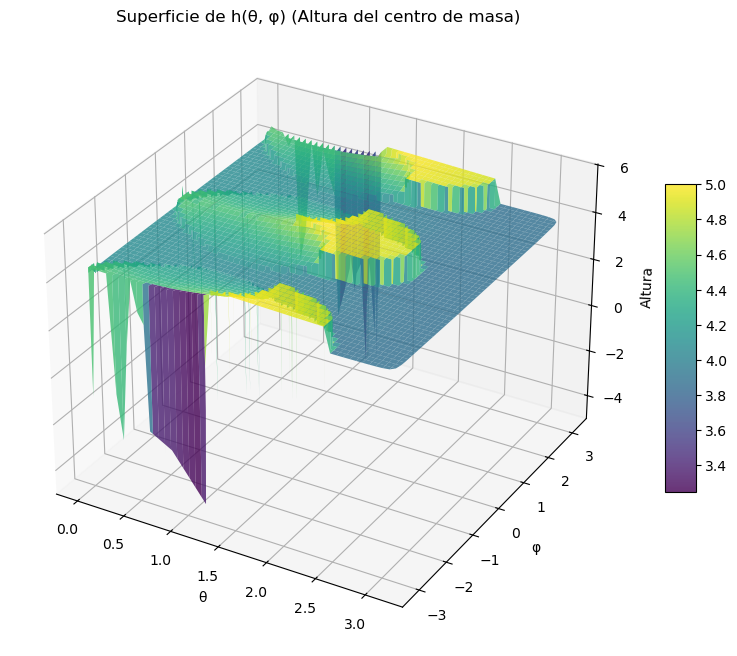

In [90]:
# --- INTERPOLACIÓN PARA GRAFICAR COMO SUPERFICIE ---
# Se asume que theta está en [0, π] y phi en [-π, π].
theta_lin = np.linspace(0, np.pi, 10000)
phi_lin = np.linspace(-np.pi, np.pi, 20000)
theta_grid, phi_grid = np.meshgrid(theta_lin, phi_lin)

# Interpolar los valores de alturas (dispersos) sobre la malla regular.
points = np.column_stack((theta, phi))
grid_alturas = griddata(points, alturas, (theta_grid, phi_grid), method='linear')

# Definir los límites de Z
z_min, z_max = min(alturas), max(alturas) + 1

# Filtrar valores fuera del rango deseado
grid_alturas[(grid_alturas < z_min) | (grid_alturas > z_max)] = np.nan  # Convertirlos en NaN

# --- GRAFICAR LA SUPERFICIE ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar sin los valores fuera de zlim
surf = ax.plot_surface(theta_grid, phi_grid, grid_alturas, cmap='viridis', edgecolor='none', alpha=0.8)

ax.set_xlabel("θ")
ax.set_ylabel("φ")
ax.set_zlabel("Altura")
ax.set_zlim(z_min, z_max)
ax.set_title("Superficie de h(θ, φ) (Altura del centro de masa)")
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()